# **Preliminary Settings**

**First Steps: Localize the Dataset, Import Libraries and Set Seed**

In [1]:
# Run this snippet only if you're on Google Colab
'''from google.colab import drive
drive.mount('/gdrive')'''

"from google.colab import drive\ndrive.mount('/gdrive')"

In [2]:
# Run this directory if you're on Google Colab (to be edited based on the position of the dataset)
#%cd /gdrive/My Drive/Colab Notebooks/LabANNDL/Homework1

# Run this directory if you're in Kaggle
%cd
%cd ..

/root
/


In [3]:
import os
import tensorflow as tf
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import rotate

from PIL import Image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers

In [4]:
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 7.8 MB/s eta 0:00:00a 0:00:01


In [5]:
!pip install split-folders

In [6]:
#Suppress warnings
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [7]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

**Metadata**

In [8]:
img_height = 96
img_width = 96
input_shape = (img_height, img_width, 3)

# Kaggle directory to the dataset
image_folder = "./kaggle/input/training-dataset-homework1/training_data_final"

labels = ['Species1',
          'Species2',
          'Species3',
          'Species4',
          'Species5',
          'Species6',
          'Species7',
          'Species8']

In [9]:
def create_dataset(image_folder):
    img_data_Array=[]
    class_name=[]
    for dir1 in os.listdir(image_folder):
        if dir1 in labels:
            for file in os.listdir(os.path.join(image_folder, dir1)):
                image_path = os.path.join(image_folder, dir1, file)
                image = np.array(Image.open(image_path))
                img_data_Array.append(image)
                class_name.append(dir1)
    return img_data_Array, class_name

**Dataset Preparation**

In [10]:
# Transformations for Data augmentation with Numpy

def translate(img, shift=10, direction='right'):
    assert direction in ['right', 'left', 'down', 'up'], 'Directions should be top|up|left|right'
    img = img.copy()
    if direction == 'right':
        right_slice = img[:, -shift:].copy()
        img[:, shift:] = img[:, :-shift]
    if direction == 'left':
        left_slice = img[:, :shift].copy()
        img[:, :-shift] = img[:, shift:]
    if direction == 'down':
        down_slice = img[-shift:, :].copy()
        img[shift:, :] = img[:-shift,:]
    if direction == 'up':
        upper_slice = img[:shift, :].copy()
        img[:-shift, :] = img[shift:, :]
    return img

def rotate_img(img, angle, bg_patch=(5,5)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
    else:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img

def gaussian_noise(img, mean=0, sigma=0.03):
    img = img.copy()
    noise = np.random.normal(mean, sigma, img.shape)
    mask_overflow_upper = img+noise >= 1.0
    mask_overflow_lower = img+noise < 0
    noise[mask_overflow_upper] = 1.0
    noise[mask_overflow_lower] = 0
    img += noise
    return img

def distort(img, orientation='horizontal', func=np.sin, x_scale=0.05, y_scale=5):
    assert orientation[:3] in ['hor', 'ver'], "dist_orient should be 'horizontal'|'vertical'"
    assert func in [np.sin, np.cos], "supported functions are np.sin and np.cos"
    assert 0.00 <= x_scale <= 0.1, "x_scale should be in [0.0, 0.1]"
    assert 0 <= y_scale <= min(img.shape[0], img.shape[1]), "y_scale should be less then image size"
    img_dist = img.copy()
    
    def shift(x):
        return int(y_scale * func(np.pi * x * x_scale))
    
    for c in range(3):
        for i in range(img.shape[orientation.startswith('ver')]):
            if orientation.startswith('ver'):
                img_dist[:, i, c] = np.roll(img[:, i, c], shift(i))
            else:
                img_dist[i, :, c] = np.roll(img[i, :, c], shift(i))
            
    return img_dist


def change_channel_ratio(img, channel='r', ratio=0.5):
    assert channel in 'rgb', "Value for channel: r|g|b"
    img = img.copy()
    ci = 'rgb'.index(channel)
    img[:, :, ci] *= ratio
    return img

In [11]:
## Load dataset
image_data, classes = create_dataset(image_folder)

# Normalize data
image_data = np.array(image_data)
image_data = image_data.astype('float32')
image_data = image_data/255.

{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}


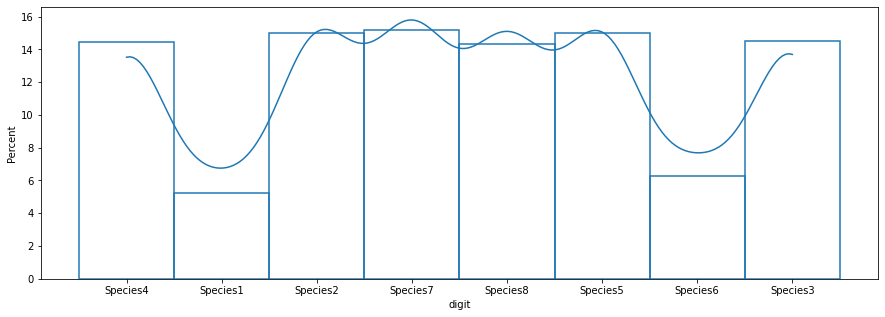

Counting occurrences of target classes:
Species7    537
Species2    532
Species5    531
Species3    515
Species4    511
Species8    508
Species6    222
Species1    186
Name: digit, dtype: int64


In [12]:
#target
target_dict = {k: v for v, k in enumerate(np.unique(classes))}
target_val = [target_dict[classes[i]] for i in range(len(classes))]
print(target_dict)

# Convert the label to categorical
y = tfk.utils.to_categorical(target_val)

# Inspect the target
plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(classes, columns=['digit']), x='digit', stat="percent", element="bars", fill=False, kde=True)
plt.show()

print('Counting occurrences of target classes:')
print(pd.DataFrame(classes, columns=['digit'])['digit'].value_counts())

In [13]:
from tensorflow.python.ops.control_flow_ops import switch
##CREATION OF TRAIN, VAL, TEST FOLDERS

# Split in train + validation and test
x_train_val, x_test, y_train_val, y_test = train_test_split(image_data, y, random_state=seed, test_size=.15)
print('train + val size: ',  x_train_val.shape, y_train_val.shape, '\ntest size: ', x_test.shape, y_test.shape)

# Split in train and validation 
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=seed, test_size=.15, stratify=y_train_val)
print('train size: ', x_train.shape, y_train.shape, '\nval size: ', x_val.shape, y_val.shape)


train + val size:  (3010, 96, 96, 3) (3010, 8) 
test size:  (532, 96, 96, 3) (532, 8)
train size:  (2558, 96, 96, 3) (2558, 8) 
val size:  (452, 96, 96, 3) (452, 8)


**Data Augmentation (Dataset with Numpy Arrays)**

In [14]:
# Data Augmentation

t_array = []
y_array = []
i = 0

for image in x_train:

    value = random.randint(1,4)
    
    if value == 1:
        # Translation
        t = np.array(translate(image, 10, random.choice(['up', 'down', 'left', 'right'])))
        t_array.append(t)
        y_array.append(y[i])
    
    elif value == 2:
        # Rotation
        t = np.array(rotate_img(image, random.randint(10,60)))
        t_array.append(t)
        y_array.append(y[i])

    
    elif value == 3:
        # Gaussian Noise
        t = np.array(gaussian_noise(image))
        t_array.append(t)
        y_array.append(y[i])
    
    
    else:
        # Channel ratio
        t = np.array(change_channel_ratio(image))
        t_array.append(t)
        y_array.append(y[i])
    
    i = i + 1

In [15]:
t_array = np.array(t_array)
y_array = np.array(y_array)
t_array.reshape((len(t_array), 96, 96, 3))
y_array.reshape((len(y_array), 8))

x_train = np.concatenate([x_train, t_array])
y_train = np.concatenate([y_train, y_array])

print(x_train.shape, y_train.shape)

(5116, 96, 96, 3) (5116, 8)


**Callback Function List**

In [16]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


def create_folders_and_callbacks(model_name):

    exps_dir = os.path.join('./data_augmentation_experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
      
    
    callbacks = []

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
    
    callbacks.append(ckpt_callback)


    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
    callbacks.append(es_callback)

    # Learning rate scheduler
    #------------------------
    lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    callbacks.append(lr_callback)

    return callbacks

# **Model**

**Dataset Preparation**

In [17]:
import splitfolders as sf

# Kaggle directory from /root
input_dir = './kaggle/input/training-dataset-homework1/training_data_final'
output_dir = './kaggle/working/splitted'

sf.ratio(input_dir, output=output_dir, seed=seed, ratio=(0.8, 0.1, 0.1))

train_dir = "./kaggle/working/splitted/train"
val_dir = "./kaggle/working/splitted/val"
test_dir = "./kaggle/working/splitted/test"

Copying files: 3542 files [00:04, 755.47 files/s]


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rotation_range=30,
    height_shift_range=50,
    width_shift_range=50,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True, 
    fill_mode='reflect',
    rescale=1./255
)

val_test_data_gen = ImageDataGenerator(
    rescale=1./255
)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=train_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
valid_gen = val_test_data_gen.flow_from_directory(directory=val_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = val_test_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(96,96),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


In [19]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))

    return batch

**Model Definition**

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 95, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 95, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 95, 32)   0           block1_conv1_bn[0][0]            
__________________________

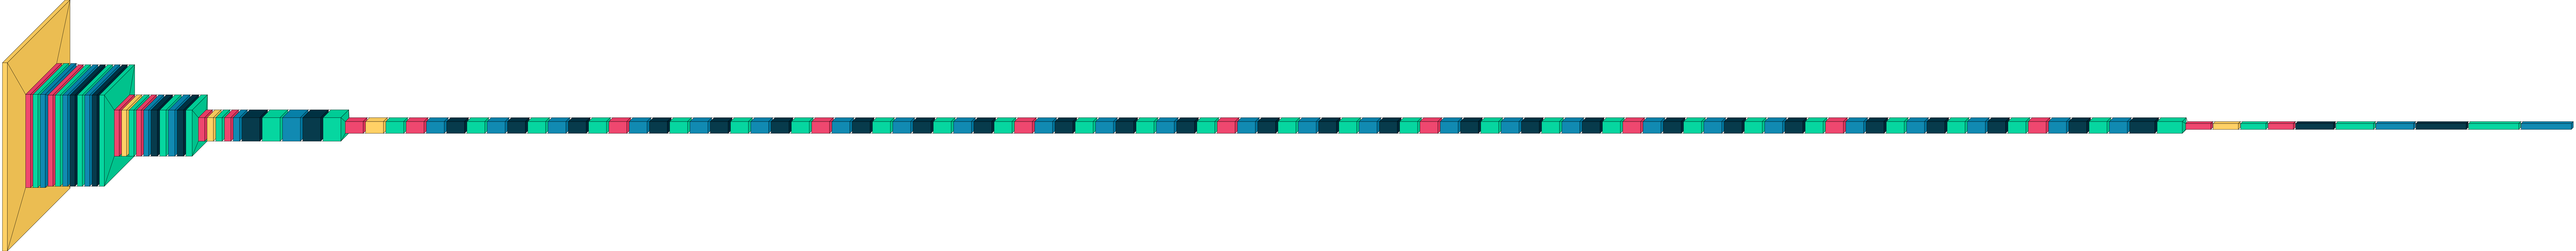

In [20]:
# Download and plot the Exception model
supernet = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(192,192,3),
    classes=8
)

visualkeras.layered_view(supernet)

**Transfer Learning and Fine Tuning**

In [21]:
supernet.trainable = True
for layer in supernet.layers[:32]:
    layer.trainable = False

In [22]:
from tensorflow.keras.layers.experimental import RandomFourierFeatures

def build_svm_model_with_trainable_weights(input_shape):
    svm_model = tfk.Sequential(
        [
            tfkl.Input(shape=input_shape),
            tfkl.Resizing(192,192),
            supernet,
            tfkl.GlobalAveragePooling2D(),
            tfkl.Dense(units = 512, 
                       activation = 'relu', 
                       kernel_initializer = tfk.initializers.HeUniform(seed), 
                       kernel_regularizer = tfk.regularizers.L1L2(5e-6, 5e-6)),
            # Quasi-SVM part
            RandomFourierFeatures(
                output_dim=4096, scale=10.0, kernel_initializer="gaussian", trainable=True
            ),
            tfkl.Dropout(0.3),
            tfkl.Dense(units=8,
                       activation='softmax',
                       kernel_initializer = tfk.initializers.GlorotUniform(seed),
                       kernel_regularizer = tfk.regularizers.L1L2(5e-6, 5e-6))
        ]
    )

    svm_model.compile(
        optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
        loss=tfk.losses.CategoricalCrossentropy(),
        metrics=[tfk.metrics.CategoricalAccuracy("accuracy")],
    )
    
    return svm_model

svm_model_t = build_svm_model_with_trainable_weights(input_shape)

In [23]:
svm_model_t.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 192, 192, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
random_fourier_features (Ran (None, 4096)              2101249   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 3

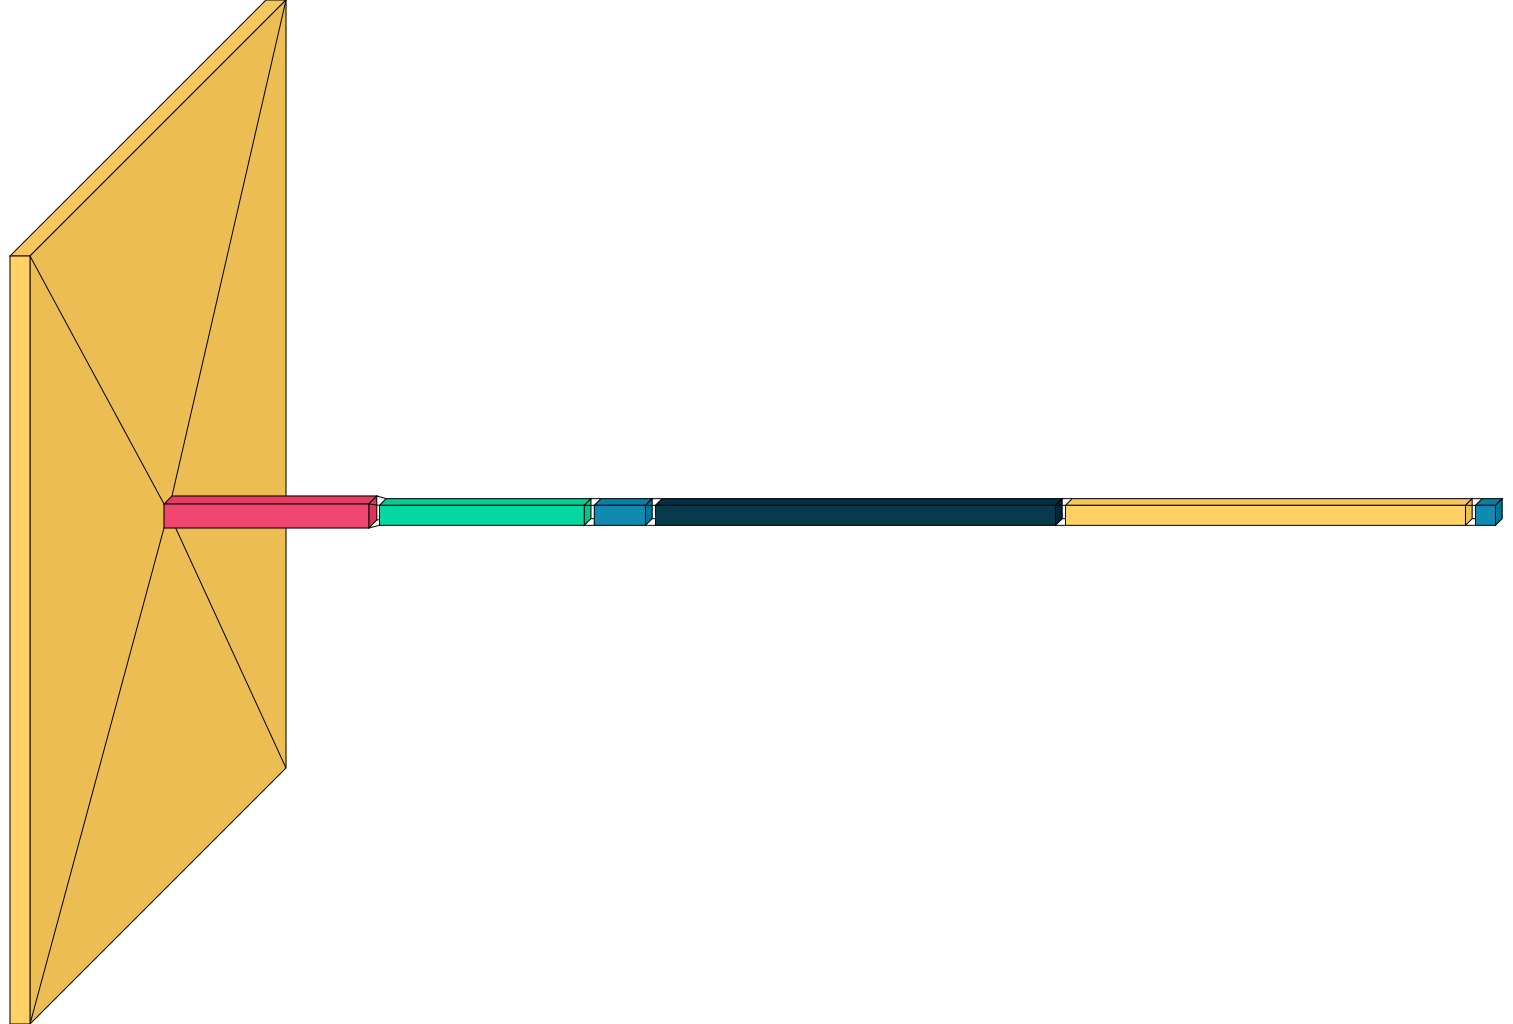

In [25]:
visualkeras.layered_view(svm_model_t)

**Training Phase**

In [26]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug_SVM_trained_weights')

# Train the model
history_svm_trainable = svm_model_t.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/200
354/354 [==============================] - 42s 80ms/step - loss: 1.8043 - accuracy: 0.4185 - val_loss: 1.3633 - val_accuracy: 0.5641
Epoch 2/200
354/354 [==============================] - 27s 76ms/step - loss: 1.3625 - accuracy: 0.5857 - val_loss: 1.2174 - val_accuracy: 0.6439
Epoch 3/200
354/354 [==============================] - 27s 77ms/step - loss: 1.1968 - accuracy: 0.6377 - val_loss: 1.0173 - val_accuracy: 0.7322
Epoch 4/200
354/354 [==============================] - 27s 76ms/step - loss: 1.1450 - accuracy: 0.6607 - val_loss: 0.7652 - val_accuracy: 0.7806
Epoch 5/200
354/354 [==============================] - 27s 76ms/step - loss: 1.0623 - accuracy: 0.6903 - val_loss: 0.9002 - val_accuracy: 0.7350
Epoch 6/200
354/354 [==============================] - 27s 76ms/step - loss: 1.0310 - accuracy: 0.7109 - val_loss: 0.9984 - val_accuracy: 0.6980
Epoch 7/200
354/354 [==============================] - 26s 74ms/step - loss: 0.9221 - accuracy: 0.7395 - val_loss: 0.8388 - val_ac

**Plot Results**

In [27]:
def plot_performance(history):
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'], label='Training Loss with TL+FT', alpha=.3, color='#4D61E2', linestyle='--')
    plt.plot(history['val_loss'], label='Validation Loss with TL+FT', alpha=.8, color='#3A41A0')
    plt.legend(loc='upper left')
    plt.title('Categorical Crossentropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(15,5))
    plt.plot(history['accuracy'], label='Training Accuracy with TL+FT', alpha=.3, color='#4D61E2', linestyle='--')
    plt.plot(history['val_accuracy'], label='Validation Accuracy with TL+FT', alpha=.8, color='#3A41A0')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()

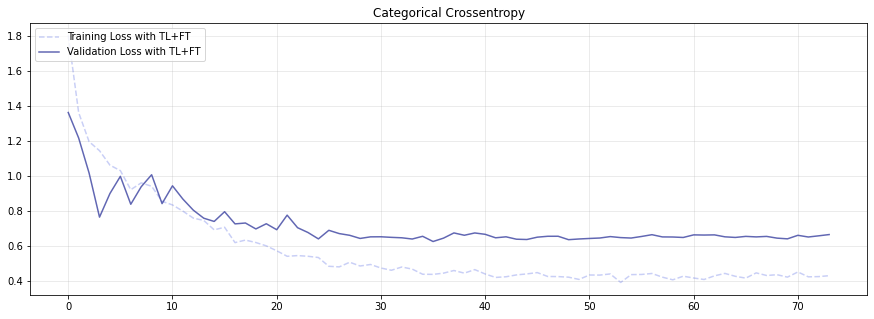

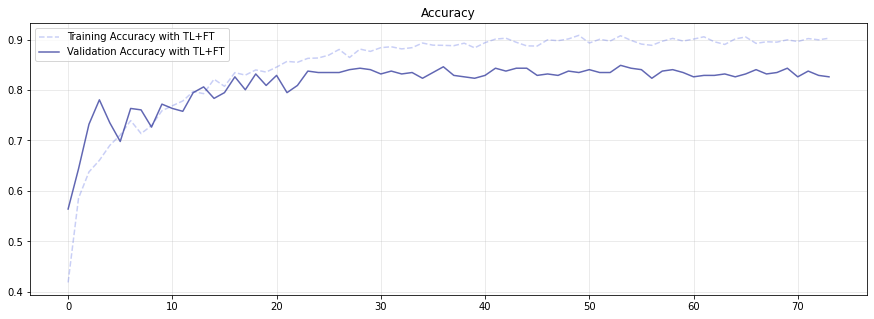

In [28]:
plot_performance(history_svm_trainable)

In [29]:
svm_model_test_metrics_trainable = svm_model_t.evaluate(test_gen, callbacks=aug_callbacks, return_dict=True)

print("Test metrics with data augmentation")
print(svm_model_test_metrics_trainable)

46/46 [==============================] - 2s 39ms/step - loss: 0.6156 - accuracy: 0.8453
Test metrics with data augmentation
{'loss': 0.6156185269355774, 'accuracy': 0.8453038930892944}


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = svm_model_t.predict_generator(test_gen, 362)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))
print('Classification Report')
print(classification_report(test_gen.classes, y_pred, target_names=labels))

Confusion Matrix
[[ 9  1  0  2  0  0  2  6]
 [ 0 49  0  0  0  0  1  4]
 [ 0  0 44  4  4  0  0  0]
 [ 0  0  0 48  3  0  0  1]
 [ 0  0  2  5 45  0  1  1]
 [ 0  3  0  1  0 18  0  1]
 [ 0  5  1  1  0  1 47  0]
 [ 0  3  1  1  0  0  1 46]]
Classification Report
              precision    recall  f1-score   support

    Species1       1.00      0.45      0.62        20
    Species2       0.80      0.91      0.85        54
    Species3       0.92      0.85      0.88        52
    Species4       0.77      0.92      0.84        52
    Species5       0.87      0.83      0.85        54
    Species6       0.95      0.78      0.86        23
    Species7       0.90      0.85      0.88        55
    Species8       0.78      0.88      0.83        52

    accuracy                           0.85       362
   macro avg       0.87      0.81      0.83       362
weighted avg       0.86      0.85      0.84       362



**K-Fold Cross Validation**

In [ ]:
from sklearn.model_selection import KFold

num_folds = 5

histories = []
scores = []

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(x_train_val, y_train_val)):

    print("Starting training on fold num: {}".format(fold_idx+1))

    history = svm_model_t.fit(
        x = x_train_val[train_idx],
        y = y_train_val[train_idx],
        validation_data=(x_train_val[valid_idx], y_train_val[valid_idx]),
        batch_size = 32,
        epochs = 200,
        callbacks=[create_folders_and_callbacks(model_name='CNN_Aug_SVM_KFold')]
    ).history

    score = svm_model_t.evaluate(x_train_val[valid_idx], y_train_val[valid_idx])
    scores.append(score[1])

    histories.append(history)

Starting training on fold num: 1
Epoch 1/200
76/76 [==============================] - 21s 274ms/step - loss: 0.2598 - accuracy: 0.9610 - val_loss: 0.2411 - val_accuracy: 0.9618
Epoch 2/200
76/76 [==============================] - 20s 265ms/step - loss: 0.2695 - accuracy: 0.9551 - val_loss: 0.2406 - val_accuracy: 0.9618
Epoch 3/200
76/76 [==============================] - 20s 258ms/step - loss: 0.2537 - accuracy: 0.9614 - val_loss: 0.2410 - val_accuracy: 0.9618
Epoch 4/200
76/76 [==============================] - 20s 259ms/step - loss: 0.2656 - accuracy: 0.9568 - val_loss: 0.2406 - val_accuracy: 0.9618
Epoch 5/200
76/76 [==============================] - 20s 263ms/step - loss: 0.2720 - accuracy: 0.9568 - val_loss: 0.2412 - val_accuracy: 0.9618
Epoch 6/200
76/76 [==============================] - 20s 264ms/step - loss: 0.2711 - accuracy: 0.9556 - val_loss: 0.2414 - val_accuracy: 0.9618
Epoch 7/200
76/76 [==============================] - 20s 263ms/step - loss: 0.2621 - accuracy: 0.9572 -

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

print("MSE")
print("Mean: {}; STD: {}".format(np.mean(scores).round(4), np.std(scores).round(4)))

plt.figure(figsize=(15,6))
for fold_idx in range(num_folds):
    plt.plot(histories[fold_idx]['val_accuracy'], color=colors[fold_idx], label='Fold N°{}'.format(fold_idx+1))
    plt.ylim(0.1, 0.9)
    plt.title('Accuracy')
    plt.legend(loc='upper right')
    plt.grid(alpha=.3)
plt.show()

In [ ]:
svm_model_t.save('kaggle/working/SubmissionModel')

In [ ]:
# The submission model is loaded in a .zip file to accelerate the download process for the submission on Codalab
!zip -r kaggle/working/SubmissionModel kaggle/working/SubmissionModel